In [12]:
import os
import warnings
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [13]:
# The first step is that we have to split the data correctly
df_final = pd.read_csv("ready_to_learn_csv.csv")

y = df_final["Price"]
X = df_final.drop(["Price"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, test_size=0.2, shuffle=True
)

In [14]:
def ordinal_encoding():
    """
    change the categorical value with the ordinal encoding method
    """
    global X_train
    global X_test

    X_train = X_train.replace(
        {
            "State_of_the_building": {
                "AS_NEW": 6,
                "JUST_RENOVATED": 5,
                "GOOD": 4,
                "TO_BE_DONE_UP": 3,
                "TO_RENOVATE": 2,
                "TO_RESTORE": 1,
            }
        }
    )  # check meaning of these
    X_test = X_test.replace(
        {
            "State_of_the_building": {
                "AS_NEW": 6,
                "JUST_RENOVATED": 5,
                "GOOD": 4,
                "TO_BE_DONE_UP": 3,
                "TO_RENOVATE": 2,
                "TO_RESTORE": 1,
            }
        }
    )
    X_train = X_train.replace(
        {
            "Subtype_of_property": {
                "PENTHOUSE": 1,
                "APARTMENT": 2,
                "DUPLEX": 3,
                "GROUND_FLOOR": 4,
                "FLAT_STUDIO": 5,
                "LOFT": 6,
                "TRIPLEX": 7,
                "SERVICE_FLAT": 8,
                "APARTMENT_GROUP": 9,
                "KOT": 10,
                "HOUSE": 11,
                "HOUSE_GROUP": 12,
                "APARTMENT_BLOCK": 13,
                "VILLA": 14,
                "MANSION": 15,
                "MIXED_USE_BUILDING": 16,
                "EXCEPTIONAL_PROPERTY": 17,
                "COUNTRY_COTTAGE": 18,
                "BUNGALOW": 19,
                "TOWN_HOUSE": 20,
                "FARMHOUSE": 21,
                "CHALET": 22,
                "CASTLE": 23,
                "OTHER_PROPERTY": 24,
                "MANOR_HOUSE": 25,
            }
        }
    )
    X_test = X_test.replace(
        {
            "Subtype_of_property": {
                "PENTHOUSE": 1,
                "APARTMENT": 2,
                "DUPLEX": 3,
                "GROUND_FLOOR": 4,
                "FLAT_STUDIO": 5,
                "LOFT": 6,
                "TRIPLEX": 7,
                "SERVICE_FLAT": 8,
                "APARTMENT_GROUP": 9,
                "KOT": 10,
                "HOUSE": 11,
                "HOUSE_GROUP": 12,
                "APARTMENT_BLOCK": 13,
                "VILLA": 14,
                "MANSION": 15,
                "MIXED_USE_BUILDING": 16,
                "EXCEPTIONAL_PROPERTY": 17,
                "COUNTRY_COTTAGE": 18,
                "BUNGALOW": 19,
                "TOWN_HOUSE": 20,
                "FARMHOUSE": 21,
                "CHALET": 22,
                "CASTLE": 23,
                "OTHER_PROPERTY": 24,
                "MANOR_HOUSE": 25,
            }
        }
    )
    X_train = X_train.replace(
        {
            "Type_of_property": {
                "APARTMENT": 1,
                "APARTMENT_GROUP": 2,
                "HOUSE": 3,
                "HOUSE_GROUP": 4,
            }
        }
    )
    X_test = X_test.replace(
        {
            "Type_of_property": {
                "APARTMENT": 1,
                "APARTMENT_GROUP": 2,
                "HOUSE": 3,
                "HOUSE_GROUP": 4,
            }
        }
    )

In [15]:
def get_median_price_per_sm():
    """
    For each localities in the X_train part, this function will compute the median price per square meter,
    then it will merge these values with X_train and X_test and will delete the collumn locality
    """
    global X_train
    global X_test

    # creation of a new dataframe, containing locality and median price per square meter of the locality (on X_train)
    area = X_train["Living_Area"] + df_final["Terrace_Area"] + df_final["Garden_Area"]
    X_train["Price_Squared_Meter"] = df_final["Price"] / area
    median_price_meter = X_train.groupby("Locality")["Price_Squared_Meter"].median()
    X_train.drop(["Price_Squared_Meter"], axis=1, inplace=True)

    # merge this new df with x_train and x_test
    X_train = X_train.merge(median_price_meter, how="left", on="Locality")
    X_test = X_test.merge(median_price_meter, how="left", on="Locality")
    # print(X_train["Price_Squared_Meter"])

    # delete Locality collumn (no more use)
    X_train.drop(["Locality"], axis=1, inplace=True)
    X_test.drop(["Locality"], axis=1, inplace=True)

In [16]:
def missing_values():
    """
    this function will deal with missing values, for the needed columns it adds a new column_wasmissing,
    and 'replace' the missing values with the help of a simple imputer
    """
    global X_train
    global X_test
    cols_with_missing = X_test.columns[
        (X_train.isna() | X_test.isna()).any().values
    ].tolist()
    for col in cols_with_missing:
        X_train[col + "_was_missing"] = X_train[col].isnull()
        X_test[col + "_was_missing"] = X_test[col].isnull()

    my_imputer = SimpleImputer()
    imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
    imputed_X_test = pd.DataFrame(my_imputer.transform(X_test))
    # Imputation removed column names; put them back
    imputed_X_train.columns = X_train.columns
    imputed_X_test.columns = X_test.columns

    X_train = imputed_X_train
    X_test = imputed_X_test

In [17]:
def preprocess():
    """
    this function will preprocess the data, it deals with nan values, non numerical values and normalize the columns
    """
    global X_train
    global X_test

    # ordinal encoding
    ordinal_encoding()

    # locality is an int but we consider it as a categorical variabe, we will replace this column by the median price per square meter for each different localities
    get_median_price_per_sm()

    # deal with missing values---------------------------------------------------------------------------------------------------------------------------------------------------------------
    missing_values()

In [18]:
preprocess()

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

model = XGBRegressor(
    learning_rate=0.07,
    max_depth=7,
    min_child_weight=4,
    n_estimators=500,
    subsample=0.7,
    colsample_bytree=0.7,
)
model.fit(X_train, y_train)

score = model.score(X_test, y_test)
print(score)

preds = model.predict(X_test)

c:\Users\Sacha\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0.7943794350465573


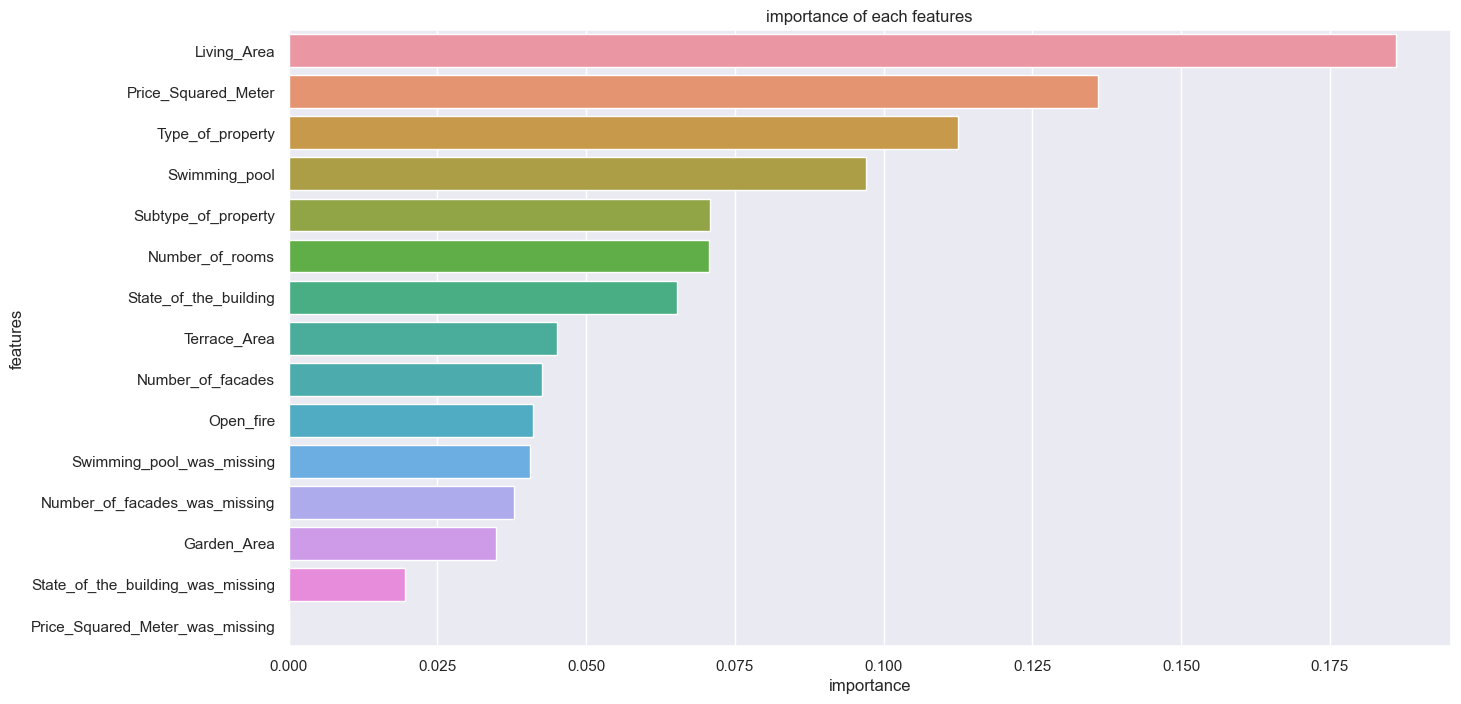

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sort feature importances in descending order
sorted_idx = np.argsort(model.feature_importances_)[::-1]

sns.set(rc={"figure.figsize": (15, 8)})
sns.barplot(
    x=model.feature_importances_[sorted_idx], y=X_train.columns[sorted_idx], orient="h"
)
plt.xlabel("importance")
plt.ylabel("features")
plt.title("importance of each features")

plt.savefig(r".\images\importance_features.png", bbox_inches="tight")
plt.show()

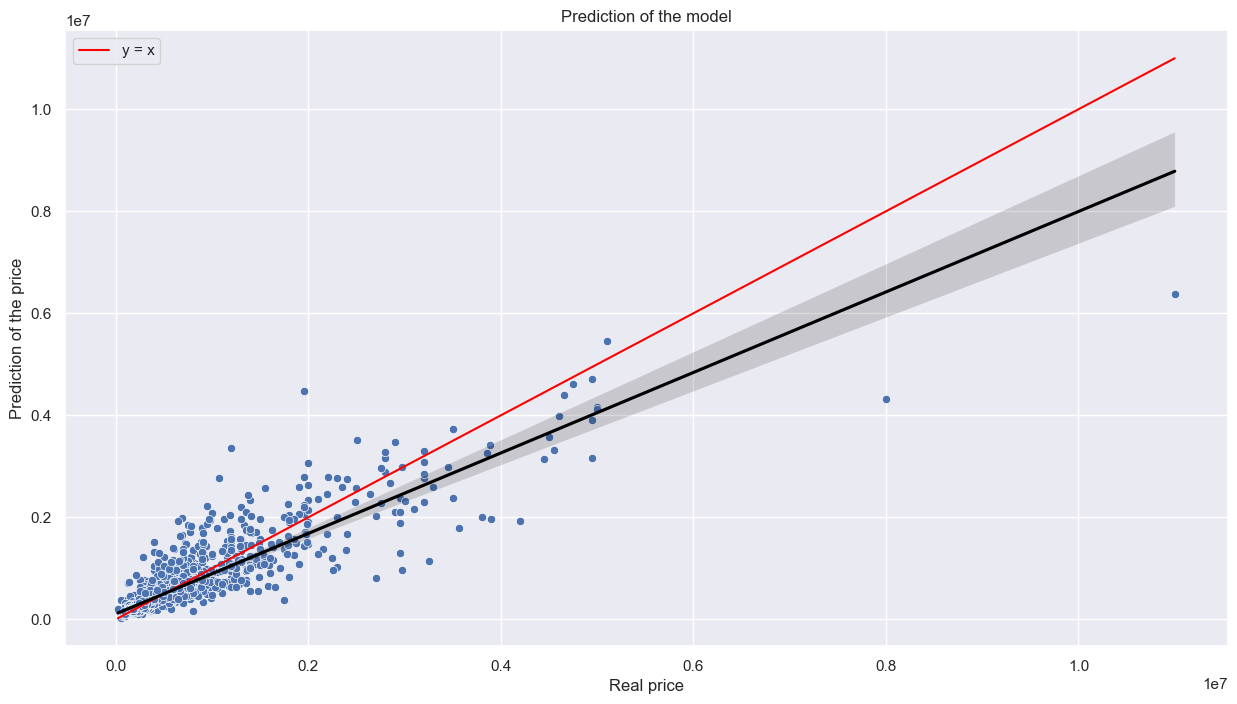

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 8))
sns.scatterplot(x=y_test, y=preds)
sns.lineplot(x=y_test, y=y_test, color="red", label="y = x")

sns.regplot(
    x=y_test, y=preds, scatter_kws={"alpha": 0}, color="black", label="linear reg"
)

plt.title("Prediction of the model")
plt.xlabel("Real price")
plt.ylabel("Prediction of the price")

plt.savefig(r".\images\efficiency_model.png", bbox_inches="tight")
plt.show()

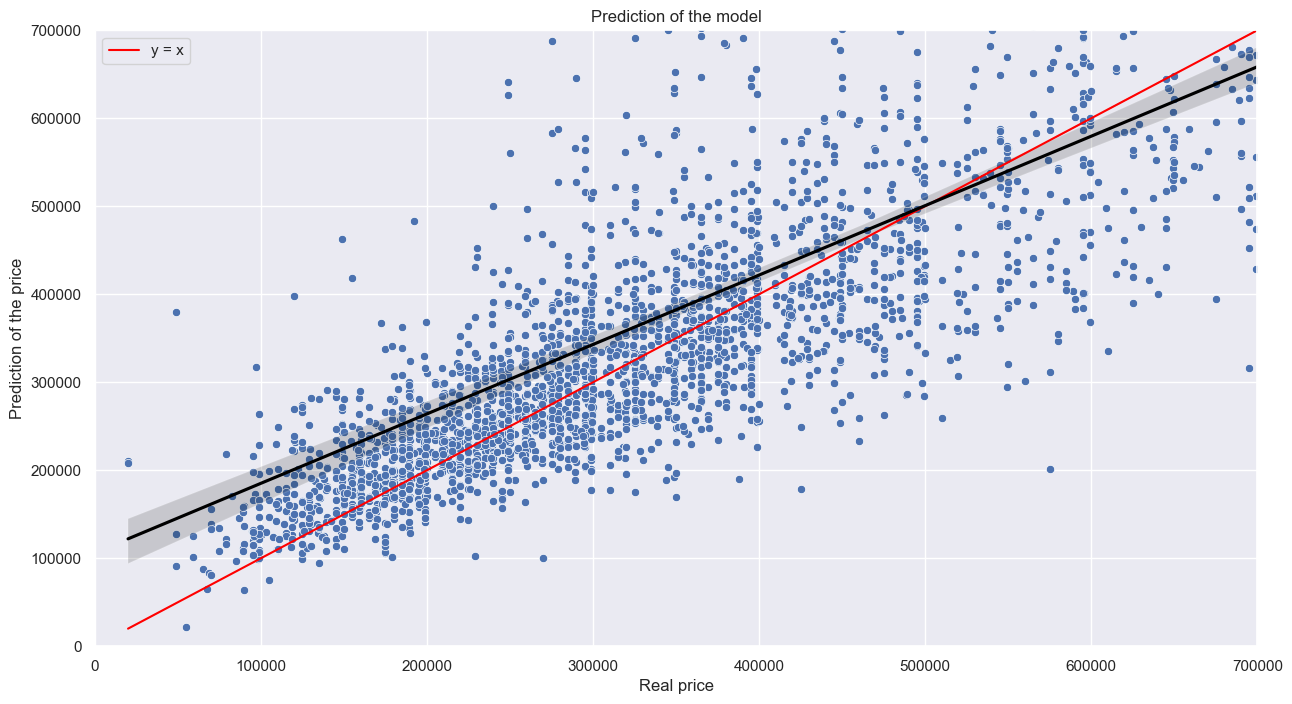

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 8))
sns.scatterplot(x=y_test, y=preds)
sns.lineplot(x=y_test, y=y_test, color="red", label="y = x")

sns.regplot(
    x=y_test, y=preds, scatter_kws={"alpha": 0}, color="black", label="linear reg"
)
plt.xlim(0, 700000)
plt.ylim(0, 700000)

plt.title("Prediction of the model")
plt.xlabel("Real price")
plt.ylabel("Prediction of the price")

plt.savefig(r".\images\efficiency_model_zoom.png", bbox_inches="tight")
plt.show()